In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install git+https://github.com/gamecicn/d3rlpy

  Cloning https://github.com/gamecicn/d3rlpy to /tmp/pip-req-build-vk9jlqqe
  Running command git clone -q https://github.com/gamecicn/d3rlpy /tmp/pip-req-build-vk9jlqqe
     |████████████████████████████████| 125 kB 14.5 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
  Created wheel for d3rlpy: filename=d3rlpy-1.0.0-cp37-cp37m-linux_x86_64.whl size=902572 sha256=d7c9c55541555a19a8eb51f720d7eaf41eceb8eea0cd502ccd3331fc60cfb105
  Stored in directory: /tmp/pip-ephem-wheel-cache-k6qyi82q/wheels/2e/27/f7/16b52fbb5b1be8f75181c4390c656081e0e6b0202a30c1915e
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e42b89e22acb7a9f67abdd6b354da09ce5201189ef624ce5075cf26d5c66c178
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built d3rlpy GPUtil


In [3]:
import d3rlpy
from d3rlpy.datasets import get_cartpole
from d3rlpy.algos import DiscreteCQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split
from d3rlpy.metrics.scorer import _make_batches

import pandas as pd
import numpy as np


# get CartPole dataset
dataset, env = get_cartpole()

Donwloading cartpole.pkl into d3rlpy_data/cartpole_replay_v1.1.0.h5...


In [9]:
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_loss(loss, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(loss)), loss)
    plt.show()

def plot_weight(TrueQ, EstiQ, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)

    plt.ylabel('Q Value')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(TrueQ)), TrueQ, label="True Q")
    plt.plot(np.arange(len(EstiQ)), EstiQ, label="Estimate Q")

    plt.legend(loc="lower right")
    plt.show() 

def get_true_Q_from_q_fucntion(
    algo, episodes
) -> float:
    WINDOW_SIZE = 1024
    GAMMA = 0.99

    total_values = []
    for episode in episodes:
        for batch in _make_batches(episode, WINDOW_SIZE, algo.n_frames):
            # estimate action-value in initial states
            actions_next = algo.predict([batch.next_observations[0]])
            values = batch.rewards[0] + GAMMA * algo.predict_value([batch.next_observations[0]], actions_next)
            total_values.append(values[0])
    return float(np.mean(total_values))


def get_true_Q_from_env(
    env, n_trials=10, epsilon =0.0, gamma=0.99, render: bool = False
):
    def scorer(algo, *args) -> float:
        episode_rewards = []
        for _ in range(n_trials):
            observation = env.reset()
            episode_reward = 0.0
            decay = 1

            while True:
                # take action
                if np.random.random() < epsilon:
                  action = env.action_space.sample()
                else:
                  action = algo.predict([observation])[0]

                observation, reward, done, _ = env.step(action)
                decay *= gamma
                episode_reward += reward * decay

                if render:
                    env.render()
                if done:
                    break
            episode_rewards.append(episode_reward)
        return float(np.mean(episode_rewards))
    return scorer

# CQL 

In [ ]:
# setup CQL algorithm
cql = DiscreteCQL(use_gpu=True)

# split train and test episodes
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

# start training
cql.fit(train_episodes,
    eval_episodes=test_episodes,
    n_epochs=100,
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
            'TrueQ': get_true_Q_from_q_fucntion, # evaluate with CartPol-v0 environment
            'EstimateQ': initial_state_value_estimation_scorer # smaller is better
        })

In [12]:
LOG_FOLDER = "/content/gdrive/MyDrive/tmp/DiscreteCQL_20220228151106/"

ESTI_Q = LOG_FOLDER + "EstimateQ.csv"
TRUE_Q = LOG_FOLDER + "TrueQ.csv"
LOSS = LOG_FOLDER + "loss.csv"

estimate_q = pd.read_csv(ESTI_Q, header = None).iloc[:,2]
true_q = pd.read_csv(TRUE_Q, header = None).iloc[:,2]
loss = pd.read_csv(LOSS, header = None).iloc[:,2]

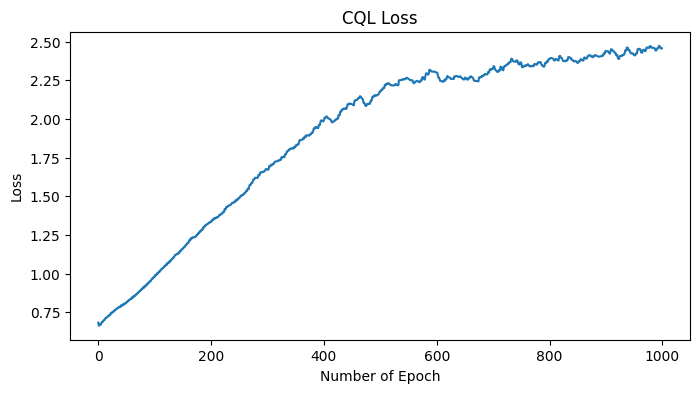

In [ ]:
plot_loss(loss, "CQL Loss")

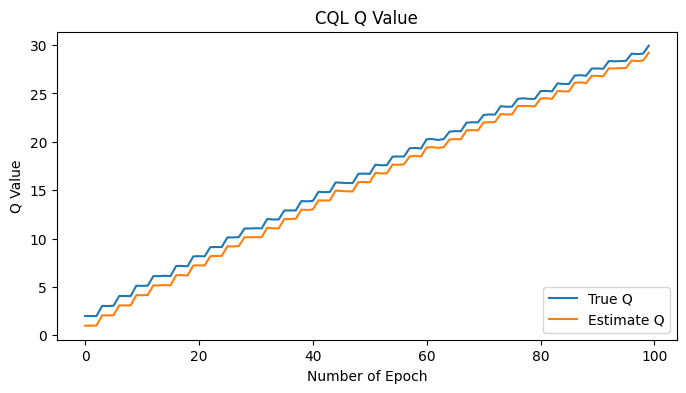

In [ ]:
plot_weight(true_q, estimate_q, "CQL Q Value")

# FEQ

In [10]:
from d3rlpy.ope import DiscreteFQE

# prepare algorithm
feq = DiscreteFQE(algo=cql)

# train
feq.fit(train_episodes,
    eval_episodes=test_episodes, 
    n_epochs=100, 
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
        'TrueQ':get_true_Q_from_q_fucntion,
        'EstimatedQ':initial_state_value_estimation_scorer
        })

2022-03-03 02:10.17 [debug    ] RoundIterator is selected.
2022-03-03 02:10.17 [info     ] Directory is created at /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017
2022-03-03 02:10.17 [debug    ] Building models...
2022-03-03 02:10.17 [debug    ] Models have been built.
2022-03-03 02:10.17 [info     ] Parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DiscreteFQ

Epoch 1/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.22 [info     ] DiscreteFQE_20220303021017: epoch=1 step=792 epoch=1 metrics={'time_sample_batch': 0.0002959421788803255, 'time_algorithm_update': 0.003763239492069591, 'loss': 0.1042518439873785, 'time_step': 0.004181590044137203, 'TrueQ': 8.202458381652832, 'EstimatedQ': 7.253878593444824} step=792
2022-03-03 02:10.22 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_792.pt


Epoch 2/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.26 [info     ] DiscreteFQE_20220303021017: epoch=2 step=1584 epoch=2 metrics={'time_sample_batch': 0.00027367141511705186, 'time_algorithm_update': 0.0035064464265649967, 'loss': 0.17556956571199334, 'time_step': 0.0038596653577053185, 'TrueQ': 15.253314971923828, 'EstimatedQ': 14.364272117614746} step=1584
2022-03-03 02:10.26 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_1584.pt


Epoch 3/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.30 [info     ] DiscreteFQE_20220303021017: epoch=3 step=2376 epoch=3 metrics={'time_sample_batch': 0.000270955189309939, 'time_algorithm_update': 0.0033974421746803055, 'loss': 0.27090465769493915, 'time_step': 0.0037511725618381694, 'TrueQ': 21.87786102294922, 'EstimatedQ': 21.075162887573242} step=2376
2022-03-03 02:10.30 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_2376.pt


Epoch 4/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.34 [info     ] DiscreteFQE_20220303021017: epoch=4 step=3168 epoch=4 metrics={'time_sample_batch': 0.00028279273196904345, 'time_algorithm_update': 0.003485940923594465, 'loss': 0.3602805950707107, 'time_step': 0.0038596963641619442, 'TrueQ': 28.01978302001953, 'EstimatedQ': 27.28679847717285} step=3168
2022-03-03 02:10.34 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_3168.pt


Epoch 5/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.38 [info     ] DiscreteFQE_20220303021017: epoch=5 step=3960 epoch=5 metrics={'time_sample_batch': 0.0002828267487612638, 'time_algorithm_update': 0.0036406149767866038, 'loss': 0.44262665061008494, 'time_step': 0.004014704564605096, 'TrueQ': 33.775272369384766, 'EstimatedQ': 33.09943389892578} step=3960
2022-03-03 02:10.38 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_3960.pt


Epoch 6/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.42 [info     ] DiscreteFQE_20220303021017: epoch=6 step=4752 epoch=6 metrics={'time_sample_batch': 0.0002785608021899907, 'time_algorithm_update': 0.0035232910604187937, 'loss': 0.518653012149805, 'time_step': 0.0038888400251215153, 'TrueQ': 39.062591552734375, 'EstimatedQ': 38.44073486328125} step=4752
2022-03-03 02:10.42 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_4752.pt


Epoch 7/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.46 [info     ] DiscreteFQE_20220303021017: epoch=7 step=5544 epoch=7 metrics={'time_sample_batch': 0.0002839059540719697, 'time_algorithm_update': 0.0035486218303140966, 'loss': 0.5880559205987157, 'time_step': 0.003923654556274414, 'TrueQ': 43.83083724975586, 'EstimatedQ': 43.255741119384766} step=5544
2022-03-03 02:10.46 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_5544.pt


Epoch 8/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.49 [info     ] DiscreteFQE_20220303021017: epoch=8 step=6336 epoch=8 metrics={'time_sample_batch': 0.00027562783222005824, 'time_algorithm_update': 0.0033697187900543213, 'loss': 0.6502294251189633, 'time_step': 0.00373027270490473, 'TrueQ': 48.26383972167969, 'EstimatedQ': 47.74589538574219} step=6336
2022-03-03 02:10.50 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_6336.pt


Epoch 9/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.54 [info     ] DiscreteFQE_20220303021017: epoch=9 step=7128 epoch=9 metrics={'time_sample_batch': 0.0002869888387545191, 'time_algorithm_update': 0.0034619756419249255, 'loss': 0.7108835979256628, 'time_step': 0.003843312913721258, 'TrueQ': 52.46281051635742, 'EstimatedQ': 51.96202850341797} step=7128
2022-03-03 02:10.54 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_7128.pt


Epoch 10/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:10.58 [info     ] DiscreteFQE_20220303021017: epoch=10 step=7920 epoch=10 metrics={'time_sample_batch': 0.000373479091759884, 'time_algorithm_update': 0.004162757083623096, 'loss': 0.7620300740089427, 'time_step': 0.004715405630342888, 'TrueQ': 56.186851501464844, 'EstimatedQ': 55.736019134521484} step=7920
2022-03-03 02:10.58 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_7920.pt


Epoch 11/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.02 [info     ] DiscreteFQE_20220303021017: epoch=11 step=8712 epoch=11 metrics={'time_sample_batch': 0.0002879596719838152, 'time_algorithm_update': 0.0035475456353389855, 'loss': 0.8112747431432856, 'time_step': 0.003933465541011155, 'TrueQ': 59.64472961425781, 'EstimatedQ': 59.23585510253906} step=8712
2022-03-03 02:11.02 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_8712.pt


Epoch 12/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.07 [info     ] DiscreteFQE_20220303021017: epoch=12 step=9504 epoch=12 metrics={'time_sample_batch': 0.00029134629952787147, 'time_algorithm_update': 0.003675140816755969, 'loss': 0.8527664642732807, 'time_step': 0.004067882744952886, 'TrueQ': 62.75661849975586, 'EstimatedQ': 62.38430404663086} step=9504
2022-03-03 02:11.07 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_9504.pt


Epoch 13/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.11 [info     ] DiscreteFQE_20220303021017: epoch=13 step=10296 epoch=13 metrics={'time_sample_batch': 0.00028920083334951687, 'time_algorithm_update': 0.0036222928702229202, 'loss': 0.8953237504389071, 'time_step': 0.004016256994671292, 'TrueQ': 65.42229461669922, 'EstimatedQ': 65.08515930175781} step=10296
2022-03-03 02:11.11 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_10296.pt


Epoch 14/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.15 [info     ] DiscreteFQE_20220303021017: epoch=14 step=11088 epoch=14 metrics={'time_sample_batch': 0.0002849652911677505, 'time_algorithm_update': 0.003567270558289807, 'loss': 0.9325920818755732, 'time_step': 0.003944741957115404, 'TrueQ': 68.20502471923828, 'EstimatedQ': 67.84236907958984} step=11088
2022-03-03 02:11.15 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_11088.pt


Epoch 15/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.19 [info     ] DiscreteFQE_20220303021017: epoch=15 step=11880 epoch=15 metrics={'time_sample_batch': 0.0002864894240793556, 'time_algorithm_update': 0.0036062351380935823, 'loss': 0.968658162014867, 'time_step': 0.003986569968136874, 'TrueQ': 70.74861145019531, 'EstimatedQ': 70.45330047607422} step=11880
2022-03-03 02:11.19 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_11880.pt


Epoch 16/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.23 [info     ] DiscreteFQE_20220303021017: epoch=16 step=12672 epoch=16 metrics={'time_sample_batch': 0.0002799136470062564, 'time_algorithm_update': 0.0035163991981082493, 'loss': 0.9972215855277774, 'time_step': 0.003883368740178118, 'TrueQ': 73.00016021728516, 'EstimatedQ': 72.73736572265625} step=12672
2022-03-03 02:11.23 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_12672.pt


Epoch 17/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.27 [info     ] DiscreteFQE_20220303021017: epoch=17 step=13464 epoch=17 metrics={'time_sample_batch': 0.00028183273594788833, 'time_algorithm_update': 0.003590980563500915, 'loss': 1.0240583907150795, 'time_step': 0.003949721955289745, 'TrueQ': 75.22570037841797, 'EstimatedQ': 74.98896789550781} step=13464
2022-03-03 02:11.27 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_13464.pt


Epoch 18/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.32 [info     ] DiscreteFQE_20220303021017: epoch=18 step=14256 epoch=18 metrics={'time_sample_batch': 0.0003821572872123333, 'time_algorithm_update': 0.004475557141833835, 'loss': 1.04744073801975, 'time_step': 0.004979619474122019, 'TrueQ': 77.1570816040039, 'EstimatedQ': 76.92494201660156} step=14256
2022-03-03 02:11.32 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_14256.pt


Epoch 19/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.36 [info     ] DiscreteFQE_20220303021017: epoch=19 step=15048 epoch=19 metrics={'time_sample_batch': 0.00028765020948467833, 'time_algorithm_update': 0.0036852272471996268, 'loss': 1.0703723980360806, 'time_step': 0.00405360171289155, 'TrueQ': 78.86734771728516, 'EstimatedQ': 78.65350341796875} step=15048
2022-03-03 02:11.36 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_15048.pt


Epoch 20/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.40 [info     ] DiscreteFQE_20220303021017: epoch=20 step=15840 epoch=20 metrics={'time_sample_batch': 0.00027987782401267926, 'time_algorithm_update': 0.0035470287607173726, 'loss': 1.0885977631639407, 'time_step': 0.003901422625840312, 'TrueQ': 80.46678161621094, 'EstimatedQ': 80.25223541259766} step=15840
2022-03-03 02:11.40 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_15840.pt


Epoch 21/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.44 [info     ] DiscreteFQE_20220303021017: epoch=21 step=16632 epoch=21 metrics={'time_sample_batch': 0.00027982183177061753, 'time_algorithm_update': 0.0036096663186044402, 'loss': 1.103088608647772, 'time_step': 0.003965476546624694, 'TrueQ': 81.93433380126953, 'EstimatedQ': 81.71538543701172} step=16632
2022-03-03 02:11.44 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_16632.pt


Epoch 22/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.48 [info     ] DiscreteFQE_20220303021017: epoch=22 step=17424 epoch=22 metrics={'time_sample_batch': 0.00028737145240860756, 'time_algorithm_update': 0.0036110983352468473, 'loss': 1.1187240619046586, 'time_step': 0.003979038710546012, 'TrueQ': 83.31989288330078, 'EstimatedQ': 83.12666320800781} step=17424
2022-03-03 02:11.48 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_17424.pt


Epoch 23/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.52 [info     ] DiscreteFQE_20220303021017: epoch=23 step=18216 epoch=23 metrics={'time_sample_batch': 0.00027402964505282313, 'time_algorithm_update': 0.0034643146726820204, 'loss': 1.1329568810402322, 'time_step': 0.0038146057514229204, 'TrueQ': 84.76708221435547, 'EstimatedQ': 84.55839538574219} step=18216
2022-03-03 02:11.52 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_18216.pt


Epoch 24/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:11.56 [info     ] DiscreteFQE_20220303021017: epoch=24 step=19008 epoch=24 metrics={'time_sample_batch': 0.0002782432117847481, 'time_algorithm_update': 0.003433960856813373, 'loss': 1.1430278464109929, 'time_step': 0.0037894056300924284, 'TrueQ': 85.95977020263672, 'EstimatedQ': 85.78679656982422} step=19008
2022-03-03 02:11.56 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_19008.pt


Epoch 25/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.00 [info     ] DiscreteFQE_20220303021017: epoch=25 step=19800 epoch=25 metrics={'time_sample_batch': 0.0002858918724638043, 'time_algorithm_update': 0.0035365816920694677, 'loss': 1.152999373435659, 'time_step': 0.003906296961235277, 'TrueQ': 86.92045593261719, 'EstimatedQ': 86.76606750488281} step=19800
2022-03-03 02:12.00 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_19800.pt


Epoch 26/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.04 [info     ] DiscreteFQE_20220303021017: epoch=26 step=20592 epoch=26 metrics={'time_sample_batch': 0.00028363683006980204, 'time_algorithm_update': 0.0034138707801549123, 'loss': 1.1614566047269042, 'time_step': 0.0037755785566387754, 'TrueQ': 88.00685119628906, 'EstimatedQ': 87.8385009765625} step=20592
2022-03-03 02:12.04 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_20592.pt


Epoch 27/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.08 [info     ] DiscreteFQE_20220303021017: epoch=27 step=21384 epoch=27 metrics={'time_sample_batch': 0.0002876673683975682, 'time_algorithm_update': 0.0035252146648638177, 'loss': 1.1663819251669043, 'time_step': 0.0038963502103632145, 'TrueQ': 88.8629379272461, 'EstimatedQ': 88.69644927978516} step=21384
2022-03-03 02:12.08 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_21384.pt


Epoch 28/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.12 [info     ] DiscreteFQE_20220303021017: epoch=28 step=22176 epoch=28 metrics={'time_sample_batch': 0.000289869127851544, 'time_algorithm_update': 0.0035054710778323088, 'loss': 1.1716299915328772, 'time_step': 0.0038852225048373445, 'TrueQ': 89.69615936279297, 'EstimatedQ': 89.54531860351562} step=22176
2022-03-03 02:12.12 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_22176.pt


Epoch 29/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.16 [info     ] DiscreteFQE_20220303021017: epoch=29 step=22968 epoch=29 metrics={'time_sample_batch': 0.0002772576279110379, 'time_algorithm_update': 0.0033996677157854794, 'loss': 1.1750151750624576, 'time_step': 0.003754840053693213, 'TrueQ': 90.53974914550781, 'EstimatedQ': 90.390869140625} step=22968
2022-03-03 02:12.16 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_22968.pt


Epoch 30/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.20 [info     ] DiscreteFQE_20220303021017: epoch=30 step=23760 epoch=30 metrics={'time_sample_batch': 0.0002822731480453954, 'time_algorithm_update': 0.0035322519263835867, 'loss': 1.1800757632978882, 'time_step': 0.00389773737300526, 'TrueQ': 91.26229858398438, 'EstimatedQ': 91.13655853271484} step=23760
2022-03-03 02:12.20 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_23760.pt


Epoch 31/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.24 [info     ] DiscreteFQE_20220303021017: epoch=31 step=24552 epoch=31 metrics={'time_sample_batch': 0.00027639456469603257, 'time_algorithm_update': 0.0034079949061075845, 'loss': 1.1868029548598436, 'time_step': 0.003761216245516382, 'TrueQ': 92.25212860107422, 'EstimatedQ': 92.14384460449219} step=24552
2022-03-03 02:12.24 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_24552.pt


Epoch 32/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.28 [info     ] DiscreteFQE_20220303021017: epoch=32 step=25344 epoch=32 metrics={'time_sample_batch': 0.00028591384791364576, 'time_algorithm_update': 0.0035432965466470428, 'loss': 1.1923358487776679, 'time_step': 0.003913089181437637, 'TrueQ': 92.94094848632812, 'EstimatedQ': 92.82071685791016} step=25344
2022-03-03 02:12.28 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_25344.pt


Epoch 33/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.32 [info     ] DiscreteFQE_20220303021017: epoch=33 step=26136 epoch=33 metrics={'time_sample_batch': 0.00028602191896149606, 'time_algorithm_update': 0.0035123734763174348, 'loss': 1.196566990690748, 'time_step': 0.003886059077099116, 'TrueQ': 93.88262939453125, 'EstimatedQ': 93.77662658691406} step=26136
2022-03-03 02:12.32 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_26136.pt


Epoch 34/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.36 [info     ] DiscreteFQE_20220303021017: epoch=34 step=26928 epoch=34 metrics={'time_sample_batch': 0.00027750748576539934, 'time_algorithm_update': 0.0034517386947015317, 'loss': 1.200276304184544, 'time_step': 0.003807585949849601, 'TrueQ': 94.62419128417969, 'EstimatedQ': 94.48313903808594} step=26928
2022-03-03 02:12.36 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_26928.pt


Epoch 35/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.40 [info     ] DiscreteFQE_20220303021017: epoch=35 step=27720 epoch=35 metrics={'time_sample_batch': 0.0002858036696308791, 'time_algorithm_update': 0.0037144121497568456, 'loss': 1.1969288463158665, 'time_step': 0.0040807290510697794, 'TrueQ': 95.20525360107422, 'EstimatedQ': 95.11101531982422} step=27720
2022-03-03 02:12.40 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_27720.pt


Epoch 36/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.44 [info     ] DiscreteFQE_20220303021017: epoch=36 step=28512 epoch=36 metrics={'time_sample_batch': 0.0002774030271202627, 'time_algorithm_update': 0.0034640012967466103, 'loss': 1.1925556015721852, 'time_step': 0.0038213615465645836, 'TrueQ': 95.41168212890625, 'EstimatedQ': 95.3185043334961} step=28512
2022-03-03 02:12.44 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_28512.pt


Epoch 37/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.48 [info     ] DiscreteFQE_20220303021017: epoch=37 step=29304 epoch=37 metrics={'time_sample_batch': 0.0002819486338682849, 'time_algorithm_update': 0.0035589623330819485, 'loss': 1.184296295761761, 'time_step': 0.003913913411323471, 'TrueQ': 95.72964477539062, 'EstimatedQ': 95.61968994140625} step=29304
2022-03-03 02:12.48 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_29304.pt


Epoch 38/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.52 [info     ] DiscreteFQE_20220303021017: epoch=38 step=30096 epoch=38 metrics={'time_sample_batch': 0.0002807351675900546, 'time_algorithm_update': 0.0035066682882983276, 'loss': 1.1843435801706756, 'time_step': 0.0038678862831809306, 'TrueQ': 96.22796630859375, 'EstimatedQ': 96.13713836669922} step=30096
2022-03-03 02:12.52 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_30096.pt


Epoch 39/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:12.56 [info     ] DiscreteFQE_20220303021017: epoch=39 step=30888 epoch=39 metrics={'time_sample_batch': 0.00027596800014226123, 'time_algorithm_update': 0.0034051137139098813, 'loss': 1.1851895855189385, 'time_step': 0.003763093189759688, 'TrueQ': 96.82371520996094, 'EstimatedQ': 96.72936248779297} step=30888
2022-03-03 02:12.56 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_30888.pt


Epoch 40/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.00 [info     ] DiscreteFQE_20220303021017: epoch=40 step=31680 epoch=40 metrics={'time_sample_batch': 0.00029614357033161203, 'time_algorithm_update': 0.0036303921781405055, 'loss': 1.1869491990420478, 'time_step': 0.004013174411022302, 'TrueQ': 97.03987884521484, 'EstimatedQ': 96.95563507080078} step=31680
2022-03-03 02:13.00 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_31680.pt


Epoch 41/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.04 [info     ] DiscreteFQE_20220303021017: epoch=41 step=32472 epoch=41 metrics={'time_sample_batch': 0.00030108473517678, 'time_algorithm_update': 0.0036543273564540978, 'loss': 1.1766850437258718, 'time_step': 0.004046127651676987, 'TrueQ': 96.86398315429688, 'EstimatedQ': 96.76461791992188} step=32472
2022-03-03 02:13.04 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_32472.pt


Epoch 42/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.08 [info     ] DiscreteFQE_20220303021017: epoch=42 step=33264 epoch=42 metrics={'time_sample_batch': 0.00029510199421584006, 'time_algorithm_update': 0.0036216260808886905, 'loss': 1.1756838336939726, 'time_step': 0.004001176718509559, 'TrueQ': 97.38623046875, 'EstimatedQ': 97.35137176513672} step=33264
2022-03-03 02:13.08 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_33264.pt


Epoch 43/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.12 [info     ] DiscreteFQE_20220303021017: epoch=43 step=34056 epoch=43 metrics={'time_sample_batch': 0.0002856868686098041, 'time_algorithm_update': 0.003475793684371794, 'loss': 1.176886459852503, 'time_step': 0.0038394888844152895, 'TrueQ': 97.75723266601562, 'EstimatedQ': 97.70215606689453} step=34056
2022-03-03 02:13.12 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_34056.pt


Epoch 44/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.16 [info     ] DiscreteFQE_20220303021017: epoch=44 step=34848 epoch=44 metrics={'time_sample_batch': 0.0002967408209136038, 'time_algorithm_update': 0.0035537448194291857, 'loss': 1.1707498520833788, 'time_step': 0.003938274251090156, 'TrueQ': 98.07054138183594, 'EstimatedQ': 97.97015380859375} step=34848
2022-03-03 02:13.16 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_34848.pt


Epoch 45/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.20 [info     ] DiscreteFQE_20220303021017: epoch=45 step=35640 epoch=45 metrics={'time_sample_batch': 0.00028592980269229775, 'time_algorithm_update': 0.0035196762494366578, 'loss': 1.1712037793718129, 'time_step': 0.0038822266188534823, 'TrueQ': 97.99565887451172, 'EstimatedQ': 97.96540069580078} step=35640
2022-03-03 02:13.20 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_35640.pt


Epoch 46/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.24 [info     ] DiscreteFQE_20220303021017: epoch=46 step=36432 epoch=46 metrics={'time_sample_batch': 0.00028557578722635907, 'time_algorithm_update': 0.0035209499224267823, 'loss': 1.1677822335340986, 'time_step': 0.003891686899493439, 'TrueQ': 98.2718276977539, 'EstimatedQ': 98.18195343017578} step=36432
2022-03-03 02:13.24 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_36432.pt


Epoch 47/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.28 [info     ] DiscreteFQE_20220303021017: epoch=47 step=37224 epoch=47 metrics={'time_sample_batch': 0.0002880830957431986, 'time_algorithm_update': 0.003431630556029503, 'loss': 1.1706462172447996, 'time_step': 0.003802295887109005, 'TrueQ': 98.55171966552734, 'EstimatedQ': 98.51203918457031} step=37224
2022-03-03 02:13.28 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_37224.pt


Epoch 48/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.32 [info     ] DiscreteFQE_20220303021017: epoch=48 step=38016 epoch=48 metrics={'time_sample_batch': 0.0002859415430011171, 'time_algorithm_update': 0.0034333139356940686, 'loss': 1.1692754099418343, 'time_step': 0.003802047534422441, 'TrueQ': 98.56392669677734, 'EstimatedQ': 98.53557586669922} step=38016
2022-03-03 02:13.32 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_38016.pt


Epoch 49/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.36 [info     ] DiscreteFQE_20220303021017: epoch=49 step=38808 epoch=49 metrics={'time_sample_batch': 0.00029397281733426183, 'time_algorithm_update': 0.0034559706244805845, 'loss': 1.1721496122437671, 'time_step': 0.003836927991924864, 'TrueQ': 98.7328872680664, 'EstimatedQ': 98.72738647460938} step=38808
2022-03-03 02:13.36 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_38808.pt


Epoch 50/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.40 [info     ] DiscreteFQE_20220303021017: epoch=50 step=39600 epoch=50 metrics={'time_sample_batch': 0.0003030432595147027, 'time_algorithm_update': 0.003594831083760117, 'loss': 1.1703745798687593, 'time_step': 0.003984074399928854, 'TrueQ': 98.76822662353516, 'EstimatedQ': 98.76589965820312} step=39600
2022-03-03 02:13.40 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_39600.pt


Epoch 51/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.44 [info     ] DiscreteFQE_20220303021017: epoch=51 step=40392 epoch=51 metrics={'time_sample_batch': 0.00029435994649174235, 'time_algorithm_update': 0.0034550145418957025, 'loss': 1.1683784868624625, 'time_step': 0.003836574578526044, 'TrueQ': 99.20413208007812, 'EstimatedQ': 99.16820526123047} step=40392
2022-03-03 02:13.44 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_40392.pt


Epoch 52/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.48 [info     ] DiscreteFQE_20220303021017: epoch=52 step=41184 epoch=52 metrics={'time_sample_batch': 0.0002965036064687401, 'time_algorithm_update': 0.0034726364444000552, 'loss': 1.1695353094761194, 'time_step': 0.003851896584636033, 'TrueQ': 99.07923126220703, 'EstimatedQ': 99.11122131347656} step=41184
2022-03-03 02:13.48 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_41184.pt


Epoch 53/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.52 [info     ] DiscreteFQE_20220303021017: epoch=53 step=41976 epoch=53 metrics={'time_sample_batch': 0.00029375998660771533, 'time_algorithm_update': 0.0036254049551607383, 'loss': 1.1640727431607443, 'time_step': 0.004002240571108731, 'TrueQ': 99.09703826904297, 'EstimatedQ': 99.09507751464844} step=41976
2022-03-03 02:13.52 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_41976.pt


Epoch 54/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:13.56 [info     ] DiscreteFQE_20220303021017: epoch=54 step=42768 epoch=54 metrics={'time_sample_batch': 0.0003043858691899463, 'time_algorithm_update': 0.003651188479529487, 'loss': 1.1592946261064045, 'time_step': 0.0040351558815349235, 'TrueQ': 99.02839660644531, 'EstimatedQ': 98.99421691894531} step=42768
2022-03-03 02:13.56 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_42768.pt


Epoch 55/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.00 [info     ] DiscreteFQE_20220303021017: epoch=55 step=43560 epoch=55 metrics={'time_sample_batch': 0.00030375640801709106, 'time_algorithm_update': 0.0035904703116176103, 'loss': 1.1531555762589731, 'time_step': 0.003977940540121059, 'TrueQ': 99.05306243896484, 'EstimatedQ': 99.08275604248047} step=43560
2022-03-03 02:14.00 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_43560.pt


Epoch 56/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.04 [info     ] DiscreteFQE_20220303021017: epoch=56 step=44352 epoch=56 metrics={'time_sample_batch': 0.0002974422291071728, 'time_algorithm_update': 0.0035435169032125764, 'loss': 1.144935478583317, 'time_step': 0.003930722523217249, 'TrueQ': 99.0609130859375, 'EstimatedQ': 99.01007080078125} step=44352
2022-03-03 02:14.04 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_44352.pt


Epoch 57/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.08 [info     ] DiscreteFQE_20220303021017: epoch=57 step=45144 epoch=57 metrics={'time_sample_batch': 0.0003027563745325262, 'time_algorithm_update': 0.0035227127749510485, 'loss': 1.1354854500222236, 'time_step': 0.003911927793965195, 'TrueQ': 99.0650405883789, 'EstimatedQ': 99.10713195800781} step=45144
2022-03-03 02:14.08 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_45144.pt


Epoch 58/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.12 [info     ] DiscreteFQE_20220303021017: epoch=58 step=45936 epoch=58 metrics={'time_sample_batch': 0.00030161274804009334, 'time_algorithm_update': 0.003570274572179775, 'loss': 1.1253487621386997, 'time_step': 0.0039607436970026805, 'TrueQ': 99.10072326660156, 'EstimatedQ': 99.10504913330078} step=45936
2022-03-03 02:14.12 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_45936.pt


Epoch 59/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.16 [info     ] DiscreteFQE_20220303021017: epoch=59 step=46728 epoch=59 metrics={'time_sample_batch': 0.0003210080392432935, 'time_algorithm_update': 0.0037396920449805984, 'loss': 1.1134396842727907, 'time_step': 0.004153945229270242, 'TrueQ': 99.02198028564453, 'EstimatedQ': 99.06546020507812} step=46728
2022-03-03 02:14.16 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_46728.pt


Epoch 60/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.20 [info     ] DiscreteFQE_20220303021017: epoch=60 step=47520 epoch=60 metrics={'time_sample_batch': 0.00029991642393247046, 'time_algorithm_update': 0.0036145834007648508, 'loss': 1.1018946924284476, 'time_step': 0.004000548762504501, 'TrueQ': 98.99372863769531, 'EstimatedQ': 99.05716705322266} step=47520
2022-03-03 02:14.20 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_47520.pt


Epoch 61/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.24 [info     ] DiscreteFQE_20220303021017: epoch=61 step=48312 epoch=61 metrics={'time_sample_batch': 0.00029147995842827693, 'time_algorithm_update': 0.0035035688467700073, 'loss': 1.0933719221690688, 'time_step': 0.0038774871464931603, 'TrueQ': 99.11366271972656, 'EstimatedQ': 99.12678527832031} step=48312
2022-03-03 02:14.24 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_48312.pt


Epoch 62/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.28 [info     ] DiscreteFQE_20220303021017: epoch=62 step=49104 epoch=62 metrics={'time_sample_batch': 0.0002965752524558944, 'time_algorithm_update': 0.0036192358744264854, 'loss': 1.0782664796535038, 'time_step': 0.003998154341572463, 'TrueQ': 98.85941314697266, 'EstimatedQ': 98.93830871582031} step=49104
2022-03-03 02:14.29 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_49104.pt


Epoch 63/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.32 [info     ] DiscreteFQE_20220303021017: epoch=63 step=49896 epoch=63 metrics={'time_sample_batch': 0.00029892000285061925, 'time_algorithm_update': 0.003503959287296642, 'loss': 1.0616317585185924, 'time_step': 0.0038830905851691662, 'TrueQ': 98.94849395751953, 'EstimatedQ': 98.98764038085938} step=49896
2022-03-03 02:14.32 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_49896.pt


Epoch 64/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.37 [info     ] DiscreteFQE_20220303021017: epoch=64 step=50688 epoch=64 metrics={'time_sample_batch': 0.00030881226664841775, 'time_algorithm_update': 0.0036265202844985808, 'loss': 1.0524509259396129, 'time_step': 0.0040212252525368124, 'TrueQ': 99.55264282226562, 'EstimatedQ': 99.66105651855469} step=50688
2022-03-03 02:14.37 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_50688.pt


Epoch 65/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.41 [info     ] DiscreteFQE_20220303021017: epoch=65 step=51480 epoch=65 metrics={'time_sample_batch': 0.0002909510424642852, 'time_algorithm_update': 0.003571171351153441, 'loss': 1.0390331052300152, 'time_step': 0.003947118316033874, 'TrueQ': 99.5913314819336, 'EstimatedQ': 99.63484191894531} step=51480
2022-03-03 02:14.41 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_51480.pt


Epoch 66/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.45 [info     ] DiscreteFQE_20220303021017: epoch=66 step=52272 epoch=66 metrics={'time_sample_batch': 0.00029209075552044493, 'time_algorithm_update': 0.0036437291689593383, 'loss': 1.0200745949916767, 'time_step': 0.004016056807354243, 'TrueQ': 99.69403076171875, 'EstimatedQ': 99.77049255371094} step=52272
2022-03-03 02:14.45 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_52272.pt


Epoch 67/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.49 [info     ] DiscreteFQE_20220303021017: epoch=67 step=53064 epoch=67 metrics={'time_sample_batch': 0.0003010838320761016, 'time_algorithm_update': 0.0036299818693989456, 'loss': 1.0032783628093322, 'time_step': 0.0040189762308139995, 'TrueQ': 99.615234375, 'EstimatedQ': 99.74752044677734} step=53064
2022-03-03 02:14.49 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_53064.pt


Epoch 68/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.53 [info     ] DiscreteFQE_20220303021017: epoch=68 step=53856 epoch=68 metrics={'time_sample_batch': 0.0002956050212937172, 'time_algorithm_update': 0.0035072832998603283, 'loss': 0.987212679537032, 'time_step': 0.003896861666380757, 'TrueQ': 99.58071899414062, 'EstimatedQ': 99.68585205078125} step=53856
2022-03-03 02:14.53 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_53856.pt


Epoch 69/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:14.57 [info     ] DiscreteFQE_20220303021017: epoch=69 step=54648 epoch=69 metrics={'time_sample_batch': 0.0002930016830714062, 'time_algorithm_update': 0.0035208099418216282, 'loss': 0.9685222407934642, 'time_step': 0.003904780655196219, 'TrueQ': 99.75535583496094, 'EstimatedQ': 99.7977294921875} step=54648
2022-03-03 02:14.57 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_54648.pt


Epoch 70/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.01 [info     ] DiscreteFQE_20220303021017: epoch=70 step=55440 epoch=70 metrics={'time_sample_batch': 0.0003067333288867064, 'time_algorithm_update': 0.0037281471069413002, 'loss': 0.9506044602021575, 'time_step': 0.004131446583102448, 'TrueQ': 99.5841293334961, 'EstimatedQ': 99.65501403808594} step=55440
2022-03-03 02:15.01 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_55440.pt


Epoch 71/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.05 [info     ] DiscreteFQE_20220303021017: epoch=71 step=56232 epoch=71 metrics={'time_sample_batch': 0.0002932533471271245, 'time_algorithm_update': 0.0035276352757155293, 'loss': 0.9285563757605474, 'time_step': 0.0039139552549882365, 'TrueQ': 99.44580841064453, 'EstimatedQ': 99.57080841064453} step=56232
2022-03-03 02:15.05 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_56232.pt


Epoch 72/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.09 [info     ] DiscreteFQE_20220303021017: epoch=72 step=57024 epoch=72 metrics={'time_sample_batch': 0.00029709634154733984, 'time_algorithm_update': 0.0035572226601417616, 'loss': 0.907775901107475, 'time_step': 0.003947141495617953, 'TrueQ': 99.32378387451172, 'EstimatedQ': 99.44308471679688} step=57024
2022-03-03 02:15.09 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_57024.pt


Epoch 73/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.13 [info     ] DiscreteFQE_20220303021017: epoch=73 step=57816 epoch=73 metrics={'time_sample_batch': 0.00029853588402873336, 'time_algorithm_update': 0.0036698922966465807, 'loss': 0.8901289043233099, 'time_step': 0.004065060555332839, 'TrueQ': 99.35640716552734, 'EstimatedQ': 99.41205596923828} step=57816
2022-03-03 02:15.13 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_57816.pt


Epoch 74/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.17 [info     ] DiscreteFQE_20220303021017: epoch=74 step=58608 epoch=74 metrics={'time_sample_batch': 0.00030134241990368774, 'time_algorithm_update': 0.0035966162127677843, 'loss': 0.8689158038151535, 'time_step': 0.003995177721736407, 'TrueQ': 99.3002700805664, 'EstimatedQ': 99.412841796875} step=58608
2022-03-03 02:15.17 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_58608.pt


Epoch 75/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.21 [info     ] DiscreteFQE_20220303021017: epoch=75 step=59400 epoch=75 metrics={'time_sample_batch': 0.0003095898363325331, 'time_algorithm_update': 0.0036926739143602776, 'loss': 0.8499679502777078, 'time_step': 0.004102395640479194, 'TrueQ': 99.17195892333984, 'EstimatedQ': 99.2660140991211} step=59400
2022-03-03 02:15.22 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_59400.pt


Epoch 76/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.26 [info     ] DiscreteFQE_20220303021017: epoch=76 step=60192 epoch=76 metrics={'time_sample_batch': 0.000295384062661065, 'time_algorithm_update': 0.003575999026346688, 'loss': 0.8339286029263578, 'time_step': 0.003966423598202792, 'TrueQ': 98.9725570678711, 'EstimatedQ': 99.0790786743164} step=60192
2022-03-03 02:15.26 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_60192.pt


Epoch 77/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.30 [info     ] DiscreteFQE_20220303021017: epoch=77 step=60984 epoch=77 metrics={'time_sample_batch': 0.0003038009609838929, 'time_algorithm_update': 0.0036858630300772312, 'loss': 0.8154954808209129, 'time_step': 0.004083792669604523, 'TrueQ': 99.03235626220703, 'EstimatedQ': 99.10697174072266} step=60984
2022-03-03 02:15.30 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_60984.pt


Epoch 78/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.34 [info     ] DiscreteFQE_20220303021017: epoch=78 step=61776 epoch=78 metrics={'time_sample_batch': 0.0003036796444594258, 'time_algorithm_update': 0.0038241774144798816, 'loss': 0.7982876341921663, 'time_step': 0.004224307609326912, 'TrueQ': 98.59986877441406, 'EstimatedQ': 98.75223541259766} step=61776
2022-03-03 02:15.34 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_61776.pt


Epoch 79/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.38 [info     ] DiscreteFQE_20220303021017: epoch=79 step=62568 epoch=79 metrics={'time_sample_batch': 0.00030605540131077623, 'time_algorithm_update': 0.0038730327529136583, 'loss': 0.7808867389091638, 'time_step': 0.004279261586642024, 'TrueQ': 98.68328857421875, 'EstimatedQ': 98.8646469116211} step=62568
2022-03-03 02:15.38 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_62568.pt


Epoch 80/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.43 [info     ] DiscreteFQE_20220303021017: epoch=80 step=63360 epoch=80 metrics={'time_sample_batch': 0.0002958238726914531, 'time_algorithm_update': 0.003756800083198933, 'loss': 0.7653671301562678, 'time_step': 0.004144723969276505, 'TrueQ': 98.42955017089844, 'EstimatedQ': 98.54077911376953} step=63360
2022-03-03 02:15.43 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_63360.pt


Epoch 81/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.47 [info     ] DiscreteFQE_20220303021017: epoch=81 step=64152 epoch=81 metrics={'time_sample_batch': 0.00029982400662971264, 'time_algorithm_update': 0.003772874673207601, 'loss': 0.7522838254732014, 'time_step': 0.004174651220591382, 'TrueQ': 98.67974853515625, 'EstimatedQ': 98.79100036621094} step=64152
2022-03-03 02:15.47 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_64152.pt


Epoch 82/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.51 [info     ] DiscreteFQE_20220303021017: epoch=82 step=64944 epoch=82 metrics={'time_sample_batch': 0.0002934631675180763, 'time_algorithm_update': 0.0037359535092055195, 'loss': 0.7390989978807141, 'time_step': 0.00412756505638662, 'TrueQ': 98.6527328491211, 'EstimatedQ': 98.72206115722656} step=64944
2022-03-03 02:15.51 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_64944.pt


Epoch 83/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.55 [info     ] DiscreteFQE_20220303021017: epoch=83 step=65736 epoch=83 metrics={'time_sample_batch': 0.0003005711719243213, 'time_algorithm_update': 0.00378088638035938, 'loss': 0.7261704259711985, 'time_step': 0.004174884521599972, 'TrueQ': 98.38518524169922, 'EstimatedQ': 98.47281646728516} step=65736
2022-03-03 02:15.55 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_65736.pt


Epoch 84/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:15.59 [info     ] DiscreteFQE_20220303021017: epoch=84 step=66528 epoch=84 metrics={'time_sample_batch': 0.000312077577668007, 'time_algorithm_update': 0.003888161194444907, 'loss': 0.7164992831525101, 'time_step': 0.0043043464121192395, 'TrueQ': 98.31836700439453, 'EstimatedQ': 98.3918685913086} step=66528
2022-03-03 02:15.59 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_66528.pt


Epoch 85/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.04 [info     ] DiscreteFQE_20220303021017: epoch=85 step=67320 epoch=85 metrics={'time_sample_batch': 0.0003071042022319755, 'time_algorithm_update': 0.0038439878309615935, 'loss': 0.7075881099309584, 'time_step': 0.0042443940735826585, 'TrueQ': 98.03955841064453, 'EstimatedQ': 98.14104461669922} step=67320
2022-03-03 02:16.04 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_67320.pt


Epoch 86/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.08 [info     ] DiscreteFQE_20220303021017: epoch=86 step=68112 epoch=86 metrics={'time_sample_batch': 0.00030470857716569994, 'time_algorithm_update': 0.003909931640432338, 'loss': 0.7014956947115033, 'time_step': 0.004310035645359695, 'TrueQ': 97.78302764892578, 'EstimatedQ': 97.84668731689453} step=68112
2022-03-03 02:16.08 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_68112.pt


Epoch 87/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.12 [info     ] DiscreteFQE_20220303021017: epoch=87 step=68904 epoch=87 metrics={'time_sample_batch': 0.0003035742827136107, 'time_algorithm_update': 0.003693222397505635, 'loss': 0.694911082124695, 'time_step': 0.004096751562272659, 'TrueQ': 97.63330841064453, 'EstimatedQ': 97.65620422363281} step=68904
2022-03-03 02:16.12 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_68904.pt


Epoch 88/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.16 [info     ] DiscreteFQE_20220303021017: epoch=88 step=69696 epoch=88 metrics={'time_sample_batch': 0.00030358451785463274, 'time_algorithm_update': 0.0036841055961570356, 'loss': 0.6925887525777774, 'time_step': 0.004086983324301363, 'TrueQ': 97.09076690673828, 'EstimatedQ': 97.16065216064453} step=69696
2022-03-03 02:16.16 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_69696.pt


Epoch 89/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.21 [info     ] DiscreteFQE_20220303021017: epoch=89 step=70488 epoch=89 metrics={'time_sample_batch': 0.00030967864123257726, 'time_algorithm_update': 0.0038115433370224153, 'loss': 0.6960180006930698, 'time_step': 0.004220060928903445, 'TrueQ': 96.68812561035156, 'EstimatedQ': 96.63117218017578} step=70488
2022-03-03 02:16.21 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_70488.pt


Epoch 90/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.25 [info     ] DiscreteFQE_20220303021017: epoch=90 step=71280 epoch=90 metrics={'time_sample_batch': 0.0003128157119558315, 'time_algorithm_update': 0.00392687621742788, 'loss': 0.6968185759074234, 'time_step': 0.004346072071730488, 'TrueQ': 96.44576263427734, 'EstimatedQ': 96.39339447021484} step=71280
2022-03-03 02:16.25 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_71280.pt


Epoch 91/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.29 [info     ] DiscreteFQE_20220303021017: epoch=91 step=72072 epoch=91 metrics={'time_sample_batch': 0.00031571376203286527, 'time_algorithm_update': 0.003929328737836896, 'loss': 0.7019538057949206, 'time_step': 0.004345886936091414, 'TrueQ': 95.51730346679688, 'EstimatedQ': 95.49352264404297} step=72072
2022-03-03 02:16.29 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_72072.pt


Epoch 92/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.34 [info     ] DiscreteFQE_20220303021017: epoch=92 step=72864 epoch=92 metrics={'time_sample_batch': 0.00029457277721828886, 'time_algorithm_update': 0.0037556492319010724, 'loss': 0.7071660518119431, 'time_step': 0.00414727402455879, 'TrueQ': 95.07543182373047, 'EstimatedQ': 95.00196838378906} step=72864
2022-03-03 02:16.34 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_72864.pt


Epoch 93/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.38 [info     ] DiscreteFQE_20220303021017: epoch=93 step=73656 epoch=93 metrics={'time_sample_batch': 0.0002889344186493845, 'time_algorithm_update': 0.0036650017054394037, 'loss': 0.7132672761011907, 'time_step': 0.004046890169683129, 'TrueQ': 94.39046478271484, 'EstimatedQ': 94.27291107177734} step=73656
2022-03-03 02:16.38 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_73656.pt


Epoch 94/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.42 [info     ] DiscreteFQE_20220303021017: epoch=94 step=74448 epoch=94 metrics={'time_sample_batch': 0.00030484584846881906, 'time_algorithm_update': 0.0038839340812028057, 'loss': 0.7166848030891457, 'time_step': 0.004286350023866904, 'TrueQ': 93.92379760742188, 'EstimatedQ': 93.72573852539062} step=74448
2022-03-03 02:16.42 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_74448.pt


Epoch 95/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.46 [info     ] DiscreteFQE_20220303021017: epoch=95 step=75240 epoch=95 metrics={'time_sample_batch': 0.00030131893928604897, 'time_algorithm_update': 0.003922859526643849, 'loss': 0.7216678753711584, 'time_step': 0.004320256637804436, 'TrueQ': 93.22875213623047, 'EstimatedQ': 93.03572082519531} step=75240
2022-03-03 02:16.46 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_75240.pt


Epoch 96/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.51 [info     ] DiscreteFQE_20220303021017: epoch=96 step=76032 epoch=96 metrics={'time_sample_batch': 0.0003129836886820167, 'time_algorithm_update': 0.003929023790841151, 'loss': 0.726278836664866, 'time_step': 0.00434257285763519, 'TrueQ': 92.2843017578125, 'EstimatedQ': 91.98685455322266} step=76032
2022-03-03 02:16.51 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_76032.pt


Epoch 97/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:16.55 [info     ] DiscreteFQE_20220303021017: epoch=97 step=76824 epoch=97 metrics={'time_sample_batch': 0.00030010035543730765, 'time_algorithm_update': 0.003888344523882625, 'loss': 0.7305852622264112, 'time_step': 0.004282807761972601, 'TrueQ': 91.27018737792969, 'EstimatedQ': 90.98413848876953} step=76824
2022-03-03 02:16.55 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_76824.pt


Epoch 98/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:17.00 [info     ] DiscreteFQE_20220303021017: epoch=98 step=77616 epoch=98 metrics={'time_sample_batch': 0.0003263438590849289, 'time_algorithm_update': 0.00404533954581829, 'loss': 0.73828091294119, 'time_step': 0.00447224396647829, 'TrueQ': 90.75334167480469, 'EstimatedQ': 90.41795349121094} step=77616
2022-03-03 02:17.00 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_77616.pt


Epoch 99/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:17.04 [info     ] DiscreteFQE_20220303021017: epoch=99 step=78408 epoch=99 metrics={'time_sample_batch': 0.0003119032792370729, 'time_algorithm_update': 0.003917735634428082, 'loss': 0.7450084916005532, 'time_step': 0.004329468264724269, 'TrueQ': 90.25872802734375, 'EstimatedQ': 89.89424896240234} step=78408
2022-03-03 02:17.04 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_78408.pt


Epoch 100/100:   0%|          | 0/792 [00:00<?, ?it/s]

2022-03-03 02:17.08 [info     ] DiscreteFQE_20220303021017: epoch=100 step=79200 epoch=100 metrics={'time_sample_batch': 0.0003040697839525011, 'time_algorithm_update': 0.0038257888471237337, 'loss': 0.75394324212796, 'time_step': 0.004223805485349713, 'TrueQ': 89.61622619628906, 'EstimatedQ': 89.1078872680664} step=79200
2022-03-03 02:17.08 [info     ] Model parameters are saved to /content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/model_79200.pt


[(1,
  {'EstimatedQ': 7.253878593444824,
   'TrueQ': 8.202458381652832,
   'loss': 0.1042518439873785,
   'time_algorithm_update': 0.003763239492069591,
   'time_sample_batch': 0.0002959421788803255,
   'time_step': 0.004181590044137203}),
 (2,
  {'EstimatedQ': 14.364272117614746,
   'TrueQ': 15.253314971923828,
   'loss': 0.17556956571199334,
   'time_algorithm_update': 0.0035064464265649967,
   'time_sample_batch': 0.00027367141511705186,
   'time_step': 0.0038596653577053185}),
 (3,
  {'EstimatedQ': 21.075162887573242,
   'TrueQ': 21.87786102294922,
   'loss': 0.27090465769493915,
   'time_algorithm_update': 0.0033974421746803055,
   'time_sample_batch': 0.000270955189309939,
   'time_step': 0.0037511725618381694}),
 (4,
  {'EstimatedQ': 27.28679847717285,
   'TrueQ': 28.01978302001953,
   'loss': 0.3602805950707107,
   'time_algorithm_update': 0.003485940923594465,
   'time_sample_batch': 0.00028279273196904345,
   'time_step': 0.0038596963641619442}),
 (5,
  {'EstimatedQ': 33.0994

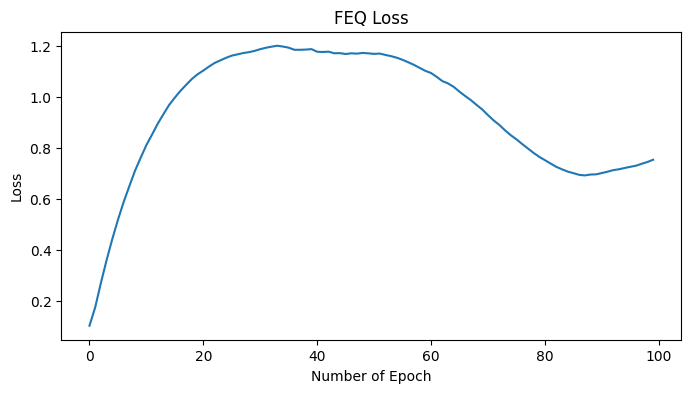

In [14]:
LOG_FOLDER = "/content/gdrive/MyDrive/tmp/DiscreteFQE_20220303021017/"

ESTI_Q = LOG_FOLDER + "EstimatedQ.csv"
TRUE_Q = LOG_FOLDER + "TrueQ.csv"
LOSS = LOG_FOLDER + "loss.csv"

estimate_q = pd.read_csv(ESTI_Q, header = None).iloc[:,2]
true_q = pd.read_csv(TRUE_Q, header = None).iloc[:,2]
loss = pd.read_csv(LOSS, header = None).iloc[:,2]

plot_loss(loss, "FEQ Loss")

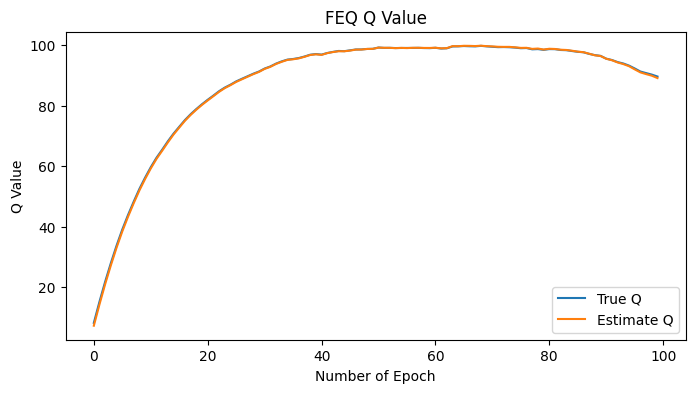

In [15]:
plot_weight(true_q, estimate_q, "FEQ Q Value")